# COMS4061A - Reinforcement Learning

## Dynamic Programming

- Mamello Seboholi [1851317]


### Imports


In [17]:
import numpy as np
import matplotlib.pyplot as plt

### MDP


In [18]:
class GridMPD:
    def __init__(self, shape: tuple[int, int], transition_reward: int, terminal_reward: int, terminal_states: list[int]):
        self.grid_size = np.prod(shape)

        self.P = dict()

        self.P["prob"] = np.full((self.grid_size, 4), 1)
        self.P["next_state"] = GridMPD.generate_next_state(shape, terminal_states)
        self.P["reward"] = np.full((self.grid_size, 4), transition_reward)
        self.P["reward"][terminal_states, :] = terminal_reward

    @staticmethod
    def generate_next_state(shape: tuple[int, int], terminal_states: list[int]):
        grid_size = np.prod(shape)
        width = shape[0]

        state = np.arange(grid_size)
        next_state = np.tile(state, 4).reshape(width, -1).transpose().reshape(shape + (-1,))

        next_state[1:, :, 0] -= width  # Up
        next_state[:, :-1, 1] += 1 # Right
        next_state[:-1, :, 2] += width # Down
        next_state[:, 1:, 3] -= 1 # Left
        
        next_state = next_state.reshape((-1, 4))
        
        for terminal_state in terminal_states:
            next_state[terminal_state, :] = terminal_state

        return next_state


In [19]:
def policy_evaluation(env: GridMPD, policy, discount_factor = 1, theta = 0.01):
    V = np.zeros(env.grid_size)
    
    prob, next_state, reward = env.P['prob'], env.P['next_state'], env.P['reward']
    
    count = 0

    while True:
        delta = 0.0
        count += 1

        for s in range(env.grid_size):
            v = V[s]
            
            V[s] = (policy[s] * prob[s]).dot(reward[s] + discount_factor * V[next_state[s]])
            
            delta = np.maximum(delta, abs(v - V[s]))

        if delta < theta:
            break
    return V, count


In [20]:
def policy_evaluation_2_array(env: GridMPD, policy, discount_factor = 1, theta = 0.01):
    V = np.zeros(env.grid_size)
    
    prob, next_state, reward = env.P['prob'], env.P['next_state'], env.P['reward']
    
    count = 0

    while True:
        delta = 0.0
        count += 1

        V_copy = V
        for s in range(env.grid_size):
            v = V_copy[s]
            
            # Note still updating in place, however we use the original values in the copied V for
            # calculations... Skips the reassignment step
            V[s] = policy[s].dot(prob[s] * (reward[s] + discount_factor * V_copy[next_state[s]]))
            
            delta = np.maximum(delta, abs(v - V[s]))

        if delta < theta:
            break
    return V, count

In [21]:
def random_policy(shape: tuple[int, int]):
    return np.full((np.prod(shape), 4), 0.25)

In [22]:
grid_shape = (4, 4)
grid_size = np.prod(grid_shape)

env = GridMPD(shape=grid_shape, transition_reward=-1,
              terminal_reward=0, terminal_states=[0])

policy = random_policy(grid_shape)


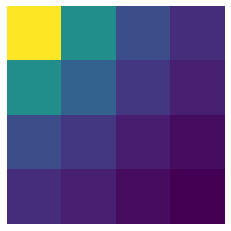

In [23]:
V_1, iterations_1 = policy_evaluation(env, policy)
plt.axis('off')
plt.imshow(V_1.reshape(grid_shape))

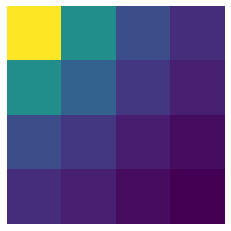

In [24]:
V_2, iterations_2 = policy_evaluation_2_array(env, policy)
plt.axis('off')
plt.imshow(V_2.reshape(grid_shape))

In [25]:
discount_factors = np.logspace(-0.2, 0, num=20)
y_axis = []
y_axis_2_array = []

for discount in discount_factors:
    y_axis.append(policy_evaluation(env, policy, discount)[1])
    y_axis_2_array.append(policy_evaluation_2_array(env, policy, discount)[1])

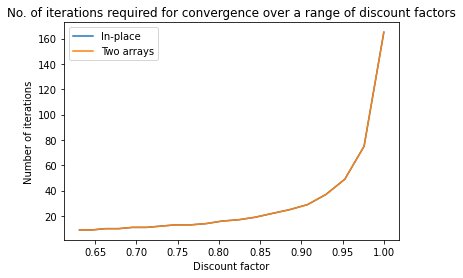

In [26]:
plt.plot(discount_factors, y_axis, label="In-place")
plt.plot(discount_factors, y_axis_2_array, label="Two arrays")
plt.title("No. of iterations required for convergence over a range of discount factors")
plt.ylabel("Number of iterations")
plt.xlabel("Discount factor")
plt.legend()
plt.show()